## Conditional BPnet model training  

The regular BPnet model needs to be trained separately for each value of temperature we're using. However, by conditioning the blocks in BPnet on the value of temperature, one can define a model that can generate samples for a range of temperatures by training just once.

In [11]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np
import matplotlib.pyplot as plt
import train #User defined module to run training loop
import ising #User defined module to prescribe ising model
import math
from BPnet import CondBPnet

In [12]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
model = CondBPnet(L=36, net_depth=3, net_width=16, kernel_size=5)
lattice = 'square'
trainer = train.Trainer(model, batch_size=100, learning_rate=0.001)
trainer.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.005, 250, 0.8, False)

In [4]:
history = trainer.var_train_loop(30, anneal=True, mean=0.44, delta=0.05)

100%|██████████| 30/30 [03:11<00:00,  6.39s/it]


Testing code

In [3]:
model = CondBPnet(L=36, net_depth=3, net_width=16, kernel_size=5)
seed = tf.Variable(np.random.randint(-2**30, 2**30, size=2, dtype=np.int32),
                                dtype=tf.int32, trainable=False)
sample = model.graph_sampler(100, 0.44, seed)

## Critical temperature evaluation

In [10]:
model = CondBPnet(48, 5, 16, 3)
model.load_weights('CondBPnet_wts/L36_D3')
betas = np.linspace(0.435, 0.465, 10, True, dtype=np.float32)
binder_48 = np.empty_like(betas)
for i,beta in enumerate(betas):
    sample = model.sample(200, beta)
    mags = np.mean(sample, axis=(1,2,3))
    binder_48[i] = np.mean(mags**4)/(np.mean(mags**2)**2)

In [8]:
model = CondBPnet(96, 5, 16, 3)
model.load_weights('CondBPnet_wts/L36_D3')
betas = np.linspace(0.435, 0.465, 10, True, dtype=np.float32)
binder_96 = np.empty_like(betas)
for i,beta in enumerate(betas):
    sample = model.sample(200, beta)
    mags = np.mean(sample, axis=(1,2,3))
    binder_96[i] = np.mean(mags**4)/(np.mean(mags**2)**2)

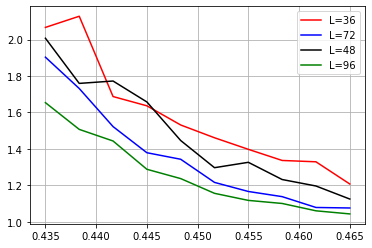

In [11]:
plt.plot(betas, binder_36, color='red', label='L=36')
plt.plot(betas, binder_72, color='blue', label='L=72')
plt.plot(betas, binder_48, color='black', label='L=48')
plt.plot(betas, binder_96, color='green', label='L=96')
plt.grid()
plt.legend()
plt.show()

In [ ]:
model = CondBPnet(L=36, kernel_size=5, net_width=16, net_depth=3)
model.log_prob()

## Smart Metropolis sampling

In regular MCMC approaches, the plots for different lengths usually converge at some point near the crtical temperature. But the autoregressive samples clearly don't converge anywhere indicating a certain inaccuracy. Hence, we create a smart Metropolis algorithm that makes use of the samples provided by this method to sample at each temperature accurately. In particular, the network samples give us Monte Carlo proposals and the acceptance rate is given by:
$$ A(X \rightarrow Y) = min \left(1,  e^{\beta[H(X)-H(Y)] + [logp(Y)-logp(X)]}\right)$$
where $logp$ is the log probability of the configuration as specified by the autoregressive network. The advantage of this mc algorithm compared to other regular ones is that there's little/no autocorrelation between different samples here.

In [13]:
def smart_mcmc(model, beta, num, tol):
    samples = model.sample(num*tol, beta)
    batch_size = 200
    log_prob = []
    for i in range((num*tol)//batch_size):
        log_prob.append(model.log_prob(samples[i*batch_size:(i+1)*batch_size], beta))
    log_prob = tf.concat(log_prob, axis=0)
    energy = ising.energy(samples)
    output_ind = np.empty(num, np.int32)
    current = 0
    gen = np.random.default_rng()
    
    for i in range(1, num*tol):
        arg = (beta*(energy[i-1]-energy[i]) +
                (log_prob[i]-log_prob[i-1]))
        if gen.uniform() < np.exp(arg):
            current = i
        if (i+1)%tol == 0:
            output_ind[((i+1)//tol) - 1] = current

    return tf.gather(samples, output_ind)

In [5]:
model = CondBPnet(36, 5, 16, 3)
model.load_weights('CondBPnet_wts/L36_D3')
betas = np.linspace(0.40, 0.48, 9, True, dtype=np.float32)
mag_36 = np.empty_like(betas)
for i,beta in enumerate(betas):
    sample = smart_mcmc(model, beta, 1000, 2)
    mags = np.mean(sample, axis=(1,2,3))
    mag_36[i] = np.mean(np.abs(mags))

<ipython-input-4-36cd8f5a9e2c>:16: RuntimeWarning: overflow encountered in exp
  if gen.uniform() < np.exp(arg):


In [17]:
np.save('Magnetizations/L36.npy', mag_36)

In [7]:
model = CondBPnet(72, 5, 16, 3)
model.load_weights('CondBPnet_wts/L36_D3')
betas = np.linspace(0.40, 0.48, 9, True, dtype=np.float32)
mag_72 = np.empty_like(betas)
for i,beta in enumerate(betas):
    sample = smart_mcmc(model, beta, 1000, 2)
    mags = np.mean(sample, axis=(1,2,3))
    mag_72[i] = np.mean(np.abs(mags))

<ipython-input-4-36cd8f5a9e2c>:16: RuntimeWarning: overflow encountered in exp
  if gen.uniform() < np.exp(arg):


In [20]:
np.save('Binder/L72.npy', binder_72)

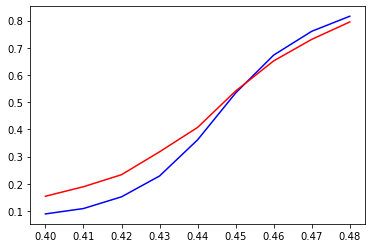

In [8]:
plt.plot(betas, mag_72, color='blue')
plt.plot(betas, mag_36, color='red')

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
mag_data = pd.read_csv("Mag_data.csv")

In [7]:
Ts = pd.Series(mag_data["Temperature"]).to_numpy()
mag_mean = pd.Series(mag_data["Magnetization mean"]).to_numpy()
mag_err = pd.Series(mag_data["Magnetization error"]).to_numpy()

<ErrorbarContainer object of 3 artists>

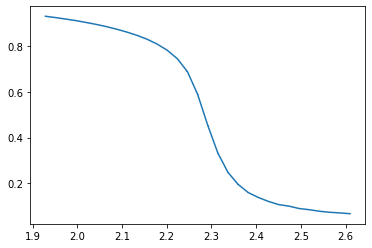

In [9]:
plt.errorbar(Ts, mag_mean)

In [14]:
model = CondBPnet(72, 5, 16, 3)
model.load_weights('CondBPnet_wts/L36_D3')
betas = 1./Ts
mag_72 = np.empty_like(betas)
for i,beta in enumerate(betas):
    sample = smart_mcmc(model, beta, 400, 2)
    mags = np.mean(sample, axis=(1,2,3))
    mag_72[i] = np.mean(np.abs(mags))

<ipython-input-13-36cd8f5a9e2c>:16: RuntimeWarning: overflow encountered in exp
  if gen.uniform() < np.exp(arg):


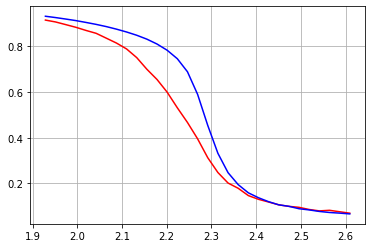

In [15]:
plt.plot(Ts, mag_72, color='red', label="BPnet")
plt.plot(Ts, mag_mean, color='blue', label="MC")
plt.grid()
plt.show()

In [17]:
1./0.49

2.0408163265306123